# CEBD1260: Full Machine Learning Pipeline
*by Hamza Benhmani & Pierre-Olivier Bonin*

> In this notebook, we use our custom function `utils.py` to aggregate, merge, and fill missing values of the Credit Risk datasets.
> Please look [here](https://github.com/gzork/the-big-short/blob/main/utils.py) for the function.

In [1]:
import lightgbm as lgb
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import ntpath
import operator
import json
import re
from utils import *
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.metrics import roc_auc_score

data_dir = "data/"

In [2]:
with open("aggr_dicts.json") as json_file:
    data_from_json = json.load(json_file)
aggr_dicts = aggr_dicts_json_to_dict(data_from_json)
aggr_dicts

{'POS_CASH_balance': {'MONTHS_BALANCE': ['max',
   'min',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'CNT_INSTALMENT': ['max',
   'min',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'CNT_INSTALMENT_FUTURE': ['max',
   'min',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'SK_DPD': ['max',
   'min',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'SK_DPD_DEF': ['max',
   'min',
   'median',
   <function utils.aggr_dicts_json_to_dict.<locals>.<lambda>(x)>],
  'NAME_CONTRACT_STATUS_Active': ['sum'],
  'NAME_CONTRACT_STATUS_Amortizeddebt': ['sum'],
  'NAME_CONTRACT_STATUS_Approved': ['sum'],
  'NAME_CONTRACT_STATUS_Completed': ['sum'],
  'NAME_CONTRACT_STATUS_Demand': ['sum'],
  'NAME_CONTRACT_STATUS_Returnedtothestore': ['sum'],
  'NAME_CONTRACT_STATUS_Signed': ['sum']},
 'credit_card_balance': {'MONTHS_BALANCE': ['max',
   'min',
   'median',
  

In [3]:
%%time
names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

dfs["application_train"].shape

CPU times: user 22.7 s, sys: 3.33 s, total: 26 s
Wall time: 27.6 s


(307511, 122)

In [4]:
def train_model():
    # main_df = preprocessing_data() we remove this since we've already done the preprocessing
    # building model
    model_lgb = lgb.LGBMClassifier(
        n_jobs=6,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.01,
        num_leaves=64,
        num_threads=4,
        max_depth=-1,
        tree_learner="serial",
        feature_fraction=0.7,
        bagging_freq=5,
        bagging_fraction=0.7,
        min_data_in_leaf=600,
        silent=-1,
        verbose=-1,
        max_bin=255,
        bagging_seed=11,
    )

    features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
    X = main_df[features]
    y = main_df['TARGET']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)

    model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc', verbose=200,
                  early_stopping_rounds=300)
    y_valid_lgb = model_lgb.predict_proba(X_valid, num_iteration=model_lgb.best_iteration_)[:, 1]

## Benchmark Model: performance is 76.3% correct prediction on 1s

In [5]:
main_df = dfs['application_train']
na_catfiller(main_df)
na_numfiller(main_df)
main_df = str_catencoder(main_df)

train_model()

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.757976	training's binary_logloss: 0.272726	valid_1's auc: 0.74671	valid_1's binary_logloss: 0.275005
[400]	training's auc: 0.770276	training's binary_logloss: 0.245325	valid_1's auc: 0.75287	valid_1's binary_logloss: 0.250409
[600]	training's auc: 0.784534	training's binary_logloss: 0.239005	valid_1's auc: 0.7594	valid_1's binary_logloss: 0.

## Aggregations and Merging

In [6]:
%%time
bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
bureau_balance.reset_index(level=0, inplace=True)
bureau_balance

CPU times: user 51.9 s, sys: 2.25 s, total: 54.1 s
Wall time: 55.7 s


,SK_ID_BUREAU,STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF
0,5001709,NaN,NaN,NaN,NaN,NaN,NaN,85.0,10.0
1,5001710,5.0,NaN,NaN,NaN,NaN,NaN,47.0,33.0
2,5001711,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,5001712,9.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN
4,5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...,...
817390,6842884,8.0,NaN,NaN,NaN,NaN,NaN,19.0,27.0
817391,6842885,11.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN
817392,6842886,7.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN
817393,6842887,5.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN


In [7]:
%%time
dfs["bureau"] = dfs["bureau"].merge(bureau_balance,on='SK_ID_BUREAU',how='left')
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

CPU times: user 932 ms, sys: 287 ms, total: 1.22 s
Wall time: 1.4 s


In [8]:
for df in dfs:
    dfs[df] = na_catfiller(dfs[df])
    dfs[df] = str_one_hot_encoder(dfs[df], 10)
    dfs[df] = na_numfiller(dfs[df])

In [9]:
%%time

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

main_df.shape, main_df.columns.tolist()

CPU times: user 9min 9s, sys: 7.83 s, total: 9min 17s
Wall time: 9min 28s


((307511, 530),
 ['SK_ID_CURR',
  'TARGET',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'APARTMENTS_AVG',
  'BASEMENTAREA_AVG',
  'YEARS_BEGINEXPLUATATION_AVG',
  'YEARS_BUILD_AVG',
  'COMMONAREA_AVG',
  'ELEVATORS_AVG',
  'ENTRANCES_AVG',
  'FLOORSMAX_AVG',
  'FLOORSMIN_AVG',
  'LANDAREA_AVG',
  'LIVINGAPARTMENTS_AVG',
  'LIVINGAREA_AVG',
  'NONLIVINGAPARTMENTS

In [10]:
main_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_min,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max_min_diff,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency1_sum,bureau_CREDIT_CURRENCY_currency2_sum,bureau_CREDIT_CURRENCY_currency3_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,8.0,0.0,7.0,8.0,2.0,6.0,0.0,8.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,6.0,6.0,6.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,6.0,6.0,6.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [11]:
main_df.isnull().sum().sum()/216

118057.24537037036

In [12]:
na_numfiller(main_df, aggregation_func="median")

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_min,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max_min_diff,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency1_sum,bureau_CREDIT_CURRENCY_currency2_sum,bureau_CREDIT_CURRENCY_currency3_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,8.0,0.0,7.0,8.0,2.0,6.0,0.0,8.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,6.0,6.0,6.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,6.0,6.0,6.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,23.0,6.0,6.0,17.0,2.0,2.0,0.0,4.0,0.0,0.0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [13]:
main_df.isnull().sum().sum()

441212

In [14]:
na_catfiller(main_df)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_min,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max_min_diff,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency1_sum,bureau_CREDIT_CURRENCY_currency2_sum,bureau_CREDIT_CURRENCY_currency3_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,8.0,0.0,7.0,8.0,2.0,6.0,0.0,8.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,6.0,6.0,6.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,6.0,6.0,6.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
307507,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
307508,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,23.0,6.0,6.0,17.0,2.0,2.0,0.0,4.0,0.0,0.0
307509,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [15]:
main_df.isnull().sum().sum()

441212

In [16]:
optimize_inttypes(main_df, specify="int32")

Memory usage of dataframe is 1.157779 GB
Total initial memory used for selected dataframe is: 1.16GB
Memory usage of dataframe is 1.107347 GB
Total memory currently used for selected dataframe is: 1.11GB


In [17]:
optimize_floattypes(main_df, specify="float32")

Memory usage of dataframe is 1.107347 GB
Total initial memory used for selected dataframe is: 1.11GB
Memory usage of dataframe is 0.590729 GB
Total memory currently used for selected dataframe is: 0.59GB


In [18]:
main_df.shape

(307511, 530)

In [19]:
main_df = str_catencoder(main_df)

In [20]:
main_df.shape

(307511, 530)

In [21]:
main_df.isnull().sum().sum()

441212

In [22]:
main_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_min,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_median,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_max_min_diff,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_CURRENCY_currency1_sum,bureau_CREDIT_CURRENCY_currency2_sum,bureau_CREDIT_CURRENCY_currency3_sum
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,8.0,0.0,7.0,8.0,2.0,6.0,0.0,8.0,0.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,6.0,6.0,6.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,6.0,6.0,6.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,6.0,6.0,6.0,0.0,2.0,3.0,0.0,4.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,6.0,6.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# Train-Test Split and Modelling using LightGBM

In [23]:
train_model()

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.772987	training's binary_logloss: 0.270475	valid_1's auc: 0.752015	valid_1's binary_logloss: 0.274576
[400]	training's auc: 0.791743	training's binary_logloss: 0.239449	valid_1's auc: 0.762402	valid_1's binary_logloss: 0.248022
[600]	training's auc: 0.811652	training's binary_logloss: 0.230046	valid_1's auc: 0.772847	valid_1's binary_logloss

> Now we need to do more feature engineering to try to improve our model. I have targeted a few columns that are not currently in use and could be added:

    In previous_application:
    * NAME_CASH_LOAN_PURPOSE
    * NAME_CONTRACT_STATUS
    * CODE_REJECT_REASON
    * ... basically all of the potentially useful categorical features.


In [24]:
main_df.shape, main_df.isnull().sum().sum()

((307511, 530), 441212)

### Try again, using a different threshold for the categorical features encoding (method_switch=50)

In [31]:
%%time

names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

for df in dfs:
    dfs[df] = na_catfiller(dfs[df])
    dfs[df] = str_one_hot_encoder(dfs[df], 10)
    dfs[df] = na_numfiller(dfs[df])
    
dfs["application_train"].shape

# bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
# bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
# bureau_balance.reset_index(level=0, inplace=True)

dfs["bureau"] = dfs["bureau_merged"]
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

na_numfiller(main_df, aggregation_func="median")
optimize_inttypes(main_df, specify="int32")
optimize_floattypes(main_df, specify="float32")
main_df = str_catencoder(main_df, method_switch=50)

Memory usage of dataframe is 1.157779 GB
Total initial memory used for selected dataframe is: 1.16GB
Memory usage of dataframe is 1.107347 GB
Total memory currently used for selected dataframe is: 1.11GB
Memory usage of dataframe is 1.107347 GB
Total initial memory used for selected dataframe is: 1.11GB
Memory usage of dataframe is 0.590729 GB
Total memory currently used for selected dataframe is: 0.59GB
CPU times: user 10min 47s, sys: 1min 44s, total: 12min 32s
Wall time: 13min 24s


In [32]:
main_df.shape

(307511, 530)

In [33]:
train_model()

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.772542	training's binary_logloss: 0.27039	valid_1's auc: 0.751622	valid_1's binary_logloss: 0.274435
[400]	training's auc: 0.792048	training's binary_logloss: 0.239388	valid_1's auc: 0.7626	valid_1's binary_logloss: 0.247919
[600]	training's auc: 0.811742	training's binary_logloss: 0.230009	valid_1's auc: 0.77227	valid_1's binary_logloss: 0.

> This is actually worse than the previous version using `str_catencoder(main_df, method_switch=10)`. Let's try more feature engineering.

# KFold cross-validation & Feature Importance

In [34]:
# get X and y, X input, y target: this is total data set X and y
features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
X = main_df[features]
y = main_df['TARGET']

#split out for some test set as if it is future unseen data, using train_test_split for now
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)
print(X_train.shape,X_test.shape,len(y_train),len(y_test))

# we reindex the objects
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

#define your lightgbm model by initializing parameters
model_lgb = lgb.LGBMClassifier(
            n_jobs=4,
            n_estimators=100000,
            boost_from_average='false',
            learning_rate=0.01,
            num_leaves=64,
            num_threads=4,
            max_depth=-1,
            tree_learner = "serial",
            feature_fraction = 0.7,
            bagging_freq = 5,
            bagging_fraction = 0.7,
            min_data_in_leaf=600,
            silent=-1,
            verbose=-1,
            max_bin = 255,
            bagging_seed = 11,
            )

#initialize KFold, we can use stratified KFold to keep the same imbalance ratio for target
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

# Use KFold to train 5 models
auc_scores = [] # save auc score for each fold
models = [] #save model for each fold
for i, (train_idx,valid_idx) in enumerate(kf.split(X_train,y_train)):
    
    print('...... training {}th fold \n'.format(i+1))
    tr_X = X_train.loc[train_idx]
    tr_y = y_train.loc[train_idx]
    
    va_X = X_train.loc[valid_idx]
    va_y = y_train.loc[valid_idx]
    
    model = model_lgb # you need to initialize your lgb model at each loop, otherwise it will overwrite
    model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (va_X, va_y)], eval_metric = 'auc', verbose=500, early_stopping_rounds = 300)
    
    # calculate current auc after training the model
    pred_va_y = model.predict_proba(va_X,num_iteration=model.best_iteration_)[:,1]
    auc = roc_auc_score(va_y,pred_va_y)
    print('current best auc score is:{}'.format(auc))
    auc_scores.append(auc)
    models.append(model)

(276759, 528) (30752, 528) 276759 30752
...... training 1th fold 

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=4 will be ignored. Current value: num_threads=4
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.807745	training's binary_logloss: 0.232599	valid_1's auc: 0.773322	valid_1's binary_logloss: 0.242672
[1000]	training's auc: 0.85027	training's binary_logloss: 0.214658	valid_1's auc: 0.785082	valid_1's binary_logloss: 0.237683
[1500]	training's auc: 0.881641	training's binar

## Evaluate the models

In [35]:
print('the average mean auc is:{}'.format(np.mean(auc_scores)))

pred_test_1 = models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]
pred_test_2 = models[1].predict_proba(X_test,num_iteration=models[1].best_iteration_)[:,1]
pred_test_3 = models[2].predict_proba(X_test,num_iteration=models[2].best_iteration_)[:,1]
pred_test_4 = models[3].predict_proba(X_test,num_iteration=models[3].best_iteration_)[:,1]
pred_test_5 = models[4].predict_proba(X_test,num_iteration=models[4].best_iteration_)[:,1]

pred_test = (pred_test_1+pred_test_2+pred_test_3+pred_test_4+pred_test_5)/5.0

models[0].predict(X_test,num_iteration=models[0].best_iteration_)

models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]

the average mean auc is:0.7858997547680643


array([0.04882051, 0.07036165, 0.11738835, ..., 0.03381582, 0.02212431,
       0.02424018])

In [36]:
fts = X_train.columns.values # all features currently used
fts

array(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG

In [37]:
fts_imp = dict(zip(fts,models[2].feature_importances_))
fts_imp = sorted(fts_imp.items(), key=operator.itemgetter(1),reverse=True)
fts_imp[:20]

[('EXT_SOURCE_2', 2771),
 ('EXT_SOURCE_1', 2357),
 ('EXT_SOURCE_3', 2259),
 ('DAYS_BIRTH', 2179),
 ('AMT_ANNUITY', 1917),
 ('AMT_CREDIT', 1792),
 ('installments_payments_AMT_PAYMENT_min', 1785),
 ('DAYS_EMPLOYED', 1492),
 ('AMT_GOODS_PRICE', 1464),
 ('DAYS_ID_PUBLISH', 1366),
 ('bureau_DAYS_CREDIT_max', 1232),
 ('DAYS_REGISTRATION', 1185),
 ('bureau_DAYS_CREDIT_ENDDATE_median', 1091),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 1054),
 ('DAYS_LAST_PHONE_CHANGE', 1030),
 ('installments_payments_AMT_PAYMENT_median', 998),
 ('installments_payments_DAYS_ENTRY_PAYMENT_max', 949),
 ('bureau_AMT_CREDIT_SUM_median', 876),
 ('POS_CASH_balance_CNT_INSTALMENT_FUTURE_median', 862),
 ('bureau_DAYS_CREDIT_median', 833)]

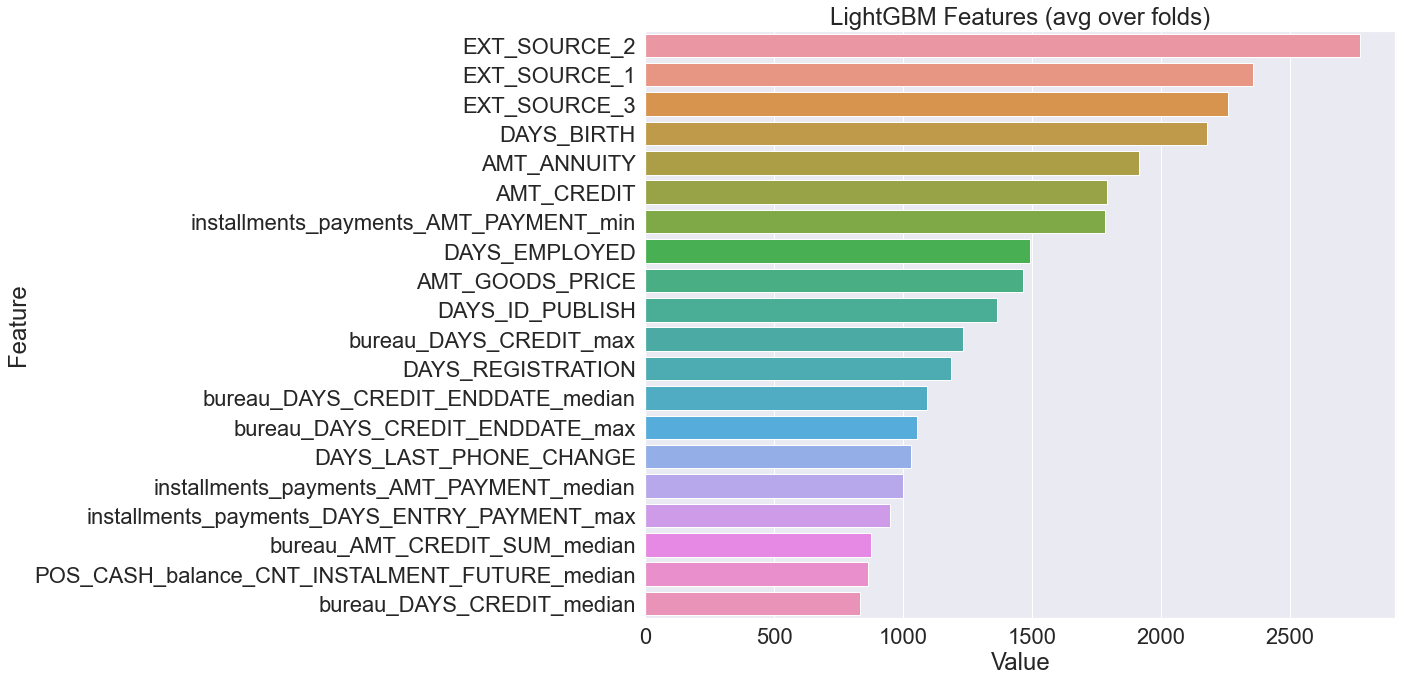

In [38]:
#print feature importance
feature_imp = pd.DataFrame({'Value':models[0].feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')
plt.show()